In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [8]:
# Expression matrix: rows are patients, columns are genes
expression = pd.read_csv("TCGA.STAD.expression.txt", sep="\t")
expression.set_index(["patient_id"], inplace=True)
expression = expression.drop("sample_id", axis=1)
expression = expression.fillna(0)

# Metadata: patient annotations
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata.set_index("patient_id", inplace=True)

# Mutation matrix (optional for this analysis, can be used for additional insights)
mutations = pd.read_csv("TCGA.STAD.mutations.txt", sep="\t")

# Unnormalized

In [9]:
expression = expression.fillna(0)
expression_scaled = expression

# PCA
pca = PCA(n_components=20) 
pca_result = pca.fit_transform(expression_scaled)
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance}")

# MDS
mds = MDS(n_components=20, random_state=42)
mds_result = mds.fit_transform(expression_scaled)

# t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(expression_scaled)

# UMAP
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_result = umap_model.fit_transform(expression_scaled)

PCA Explained Variance: [0.291529   0.21915181 0.09318604 0.05926469 0.0365876  0.03084665
 0.02109178 0.01975196 0.01566814 0.01481585 0.01334135 0.01128743
 0.01051186 0.01001313 0.00944657 0.00934993 0.00843897 0.00691838
 0.00572551 0.00522032]


/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


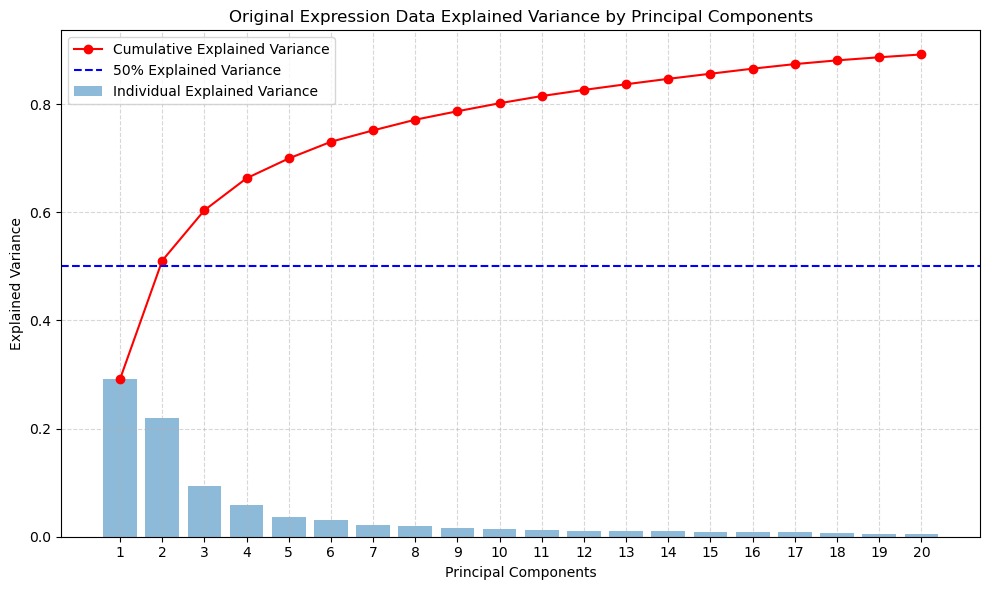

In [6]:
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.5

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Original Expression Data Explained Variance by Principal Components')
plt.xticks(np.arange(1, len(explained_variance)+1, step=1))
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=1.5, label='50% Explained Variance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
results = pd.DataFrame({
    "PCA_1": pca_result[:, 0], "PCA_2": pca_result[:, 1],
    "MDS_1": mds_result[:, 0], "MDS_2": mds_result[:, 1],
    "TSNE_1": tsne_result[:, 0], "TSNE_2": tsne_result[:, 1],
    "UMAP_1": umap_result[:, 0], "UMAP_2": umap_result[:, 1],
}, index=expression.index)
results = results.join(metadata, how="inner")

# Kmean
for dimension in [("pca", pca_result), ('mds', mds_result),('tsne', tsne_result),('umap', umap_result)]:
    input_result = dimension[1]
    name = dimension[0]
    for i in range(2, 8):
        cluster = i
        kmeans = KMeans(n_clusters=cluster, random_state=42)
        cluster_labels = kmeans.fit_predict(input_result)
        results[f"{name}_{i}_cluster"] = cluster_labels
        sil_score = silhouette_score(input_result, cluster_labels)
        print(f"Silhouette Score for K-means {name} (k={cluster}): {sil_score:.3f}")

Silhouette Score for K-means pca (k=2): 0.755
Silhouette Score for K-means pca (k=3): 0.711
Silhouette Score for K-means pca (k=4): 0.485
Silhouette Score for K-means pca (k=5): 0.498
Silhouette Score for K-means pca (k=6): 0.173
Silhouette Score for K-means pca (k=7): 0.231
Silhouette Score for K-means mds (k=2): 0.719
Silhouette Score for K-means mds (k=3): 0.663
Silhouette Score for K-means mds (k=4): 0.403
Silhouette Score for K-means mds (k=5): 0.346
Silhouette Score for K-means mds (k=6): 0.137
Silhouette Score for K-means mds (k=7): 0.153
Silhouette Score for K-means tsne (k=2): 0.272
Silhouette Score for K-means tsne (k=3): 0.294
Silhouette Score for K-means tsne (k=4): 0.267
Silhouette Score for K-means tsne (k=5): 0.269
Silhouette Score for K-means tsne (k=6): 0.262
Silhouette Score for K-means tsne (k=7): 0.276
Silhouette Score for K-means umap (k=2): 0.229
Silhouette Score for K-means umap (k=3): 0.410
Silhouette Score for K-means umap (k=4): 0.400
Silhouette Score for K-me

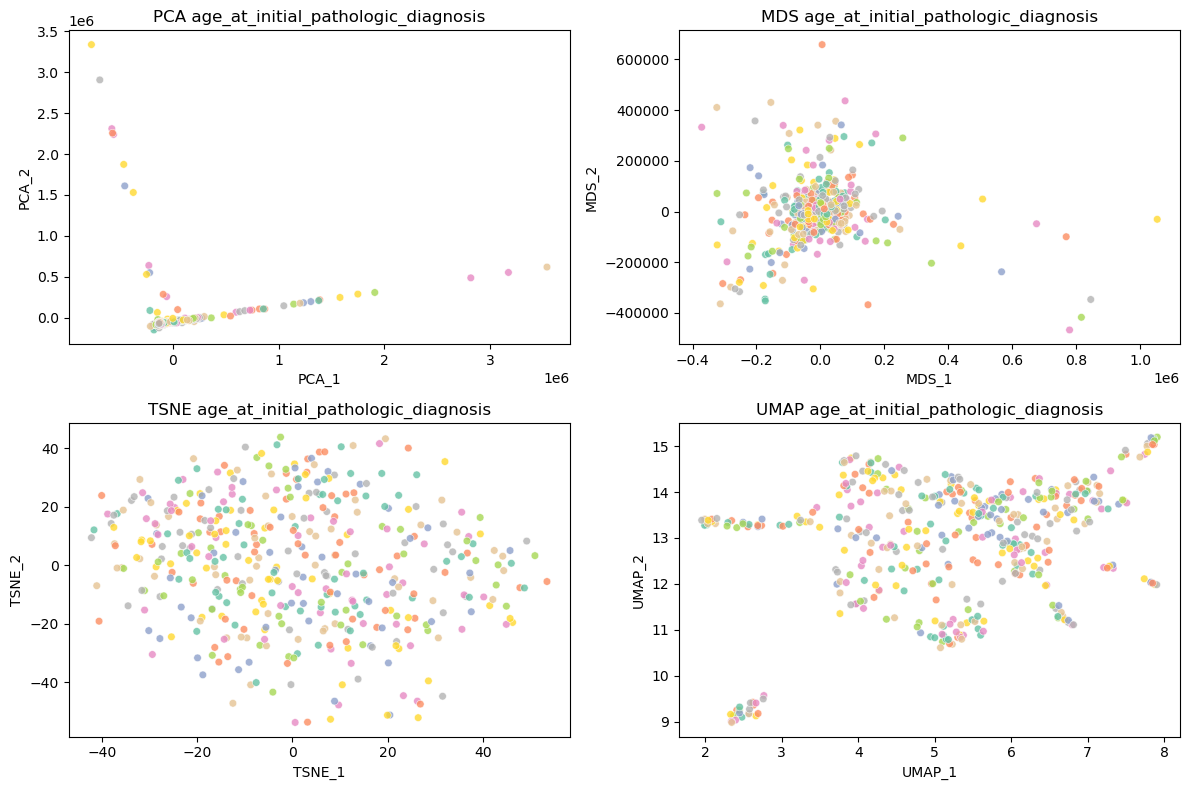

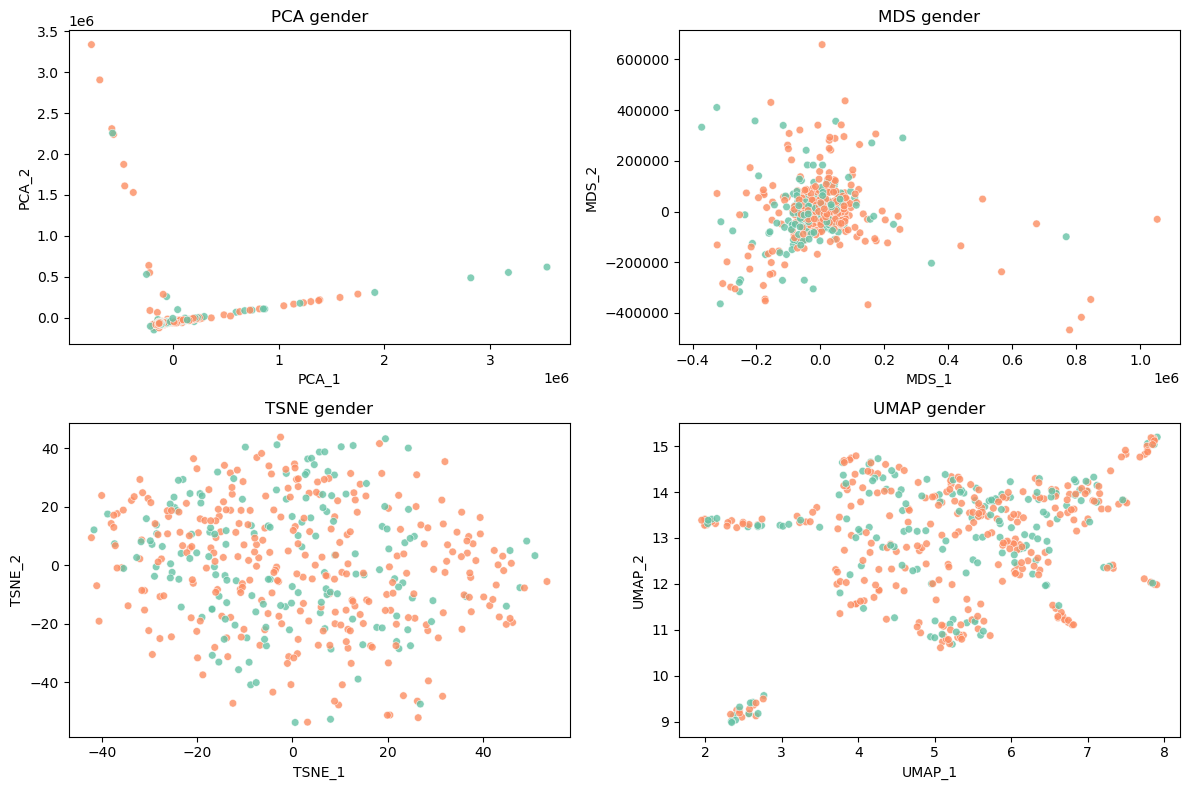

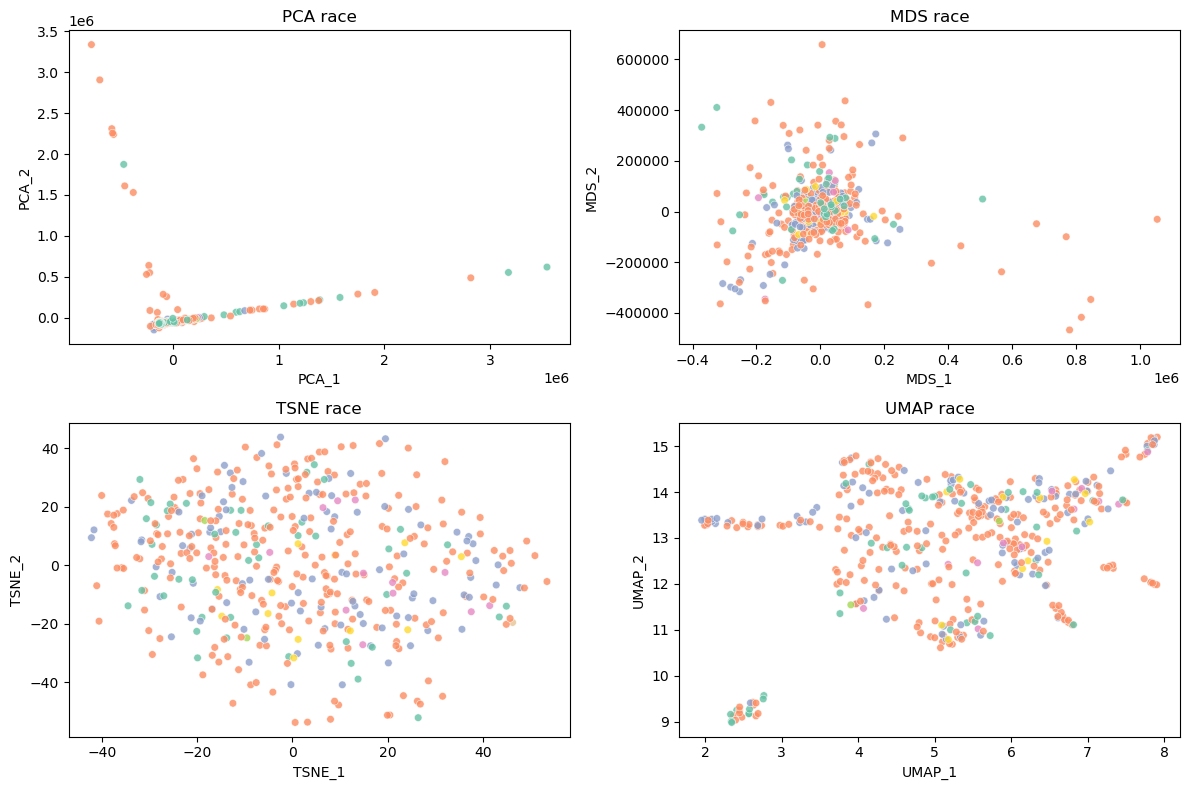

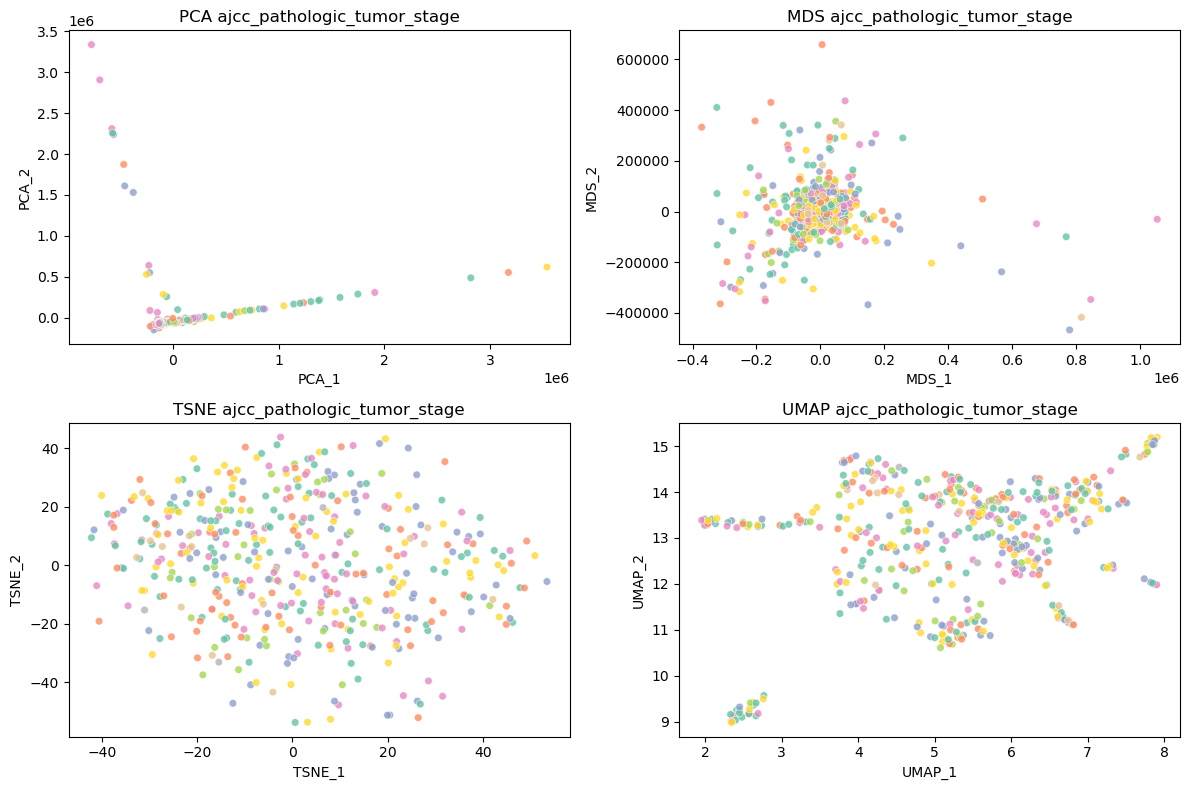

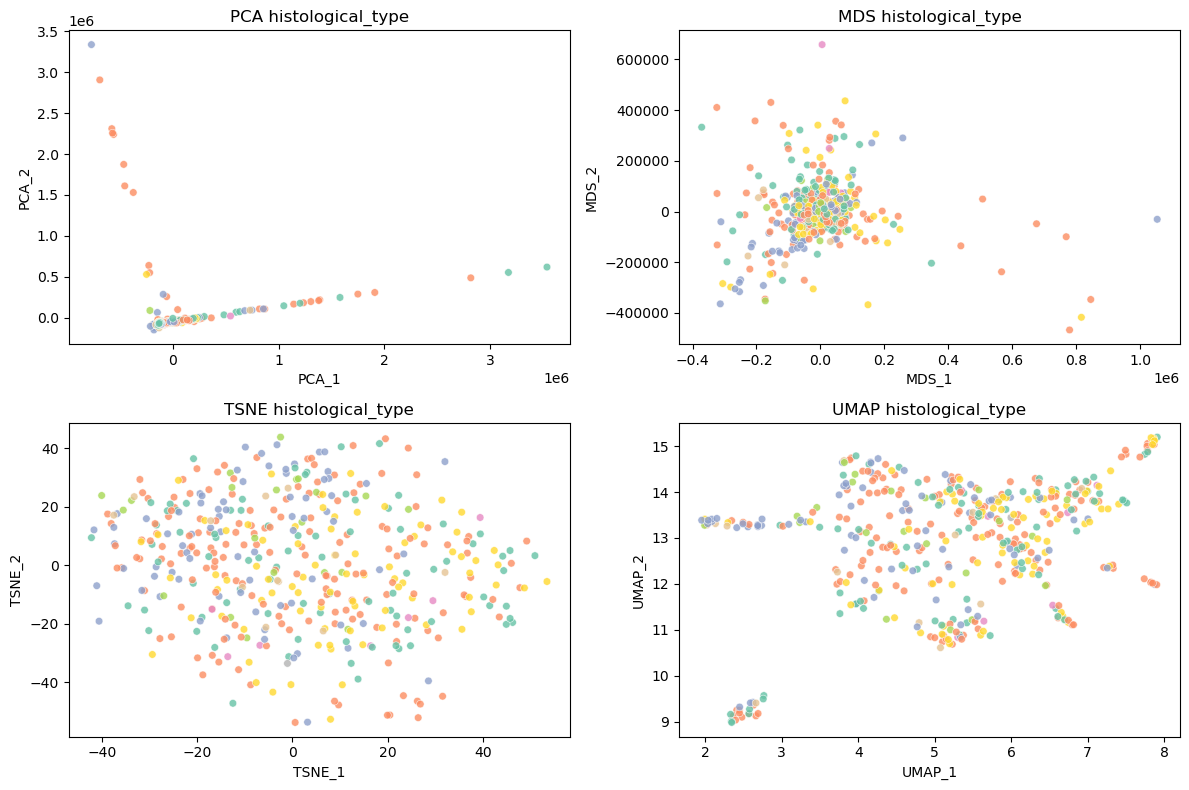

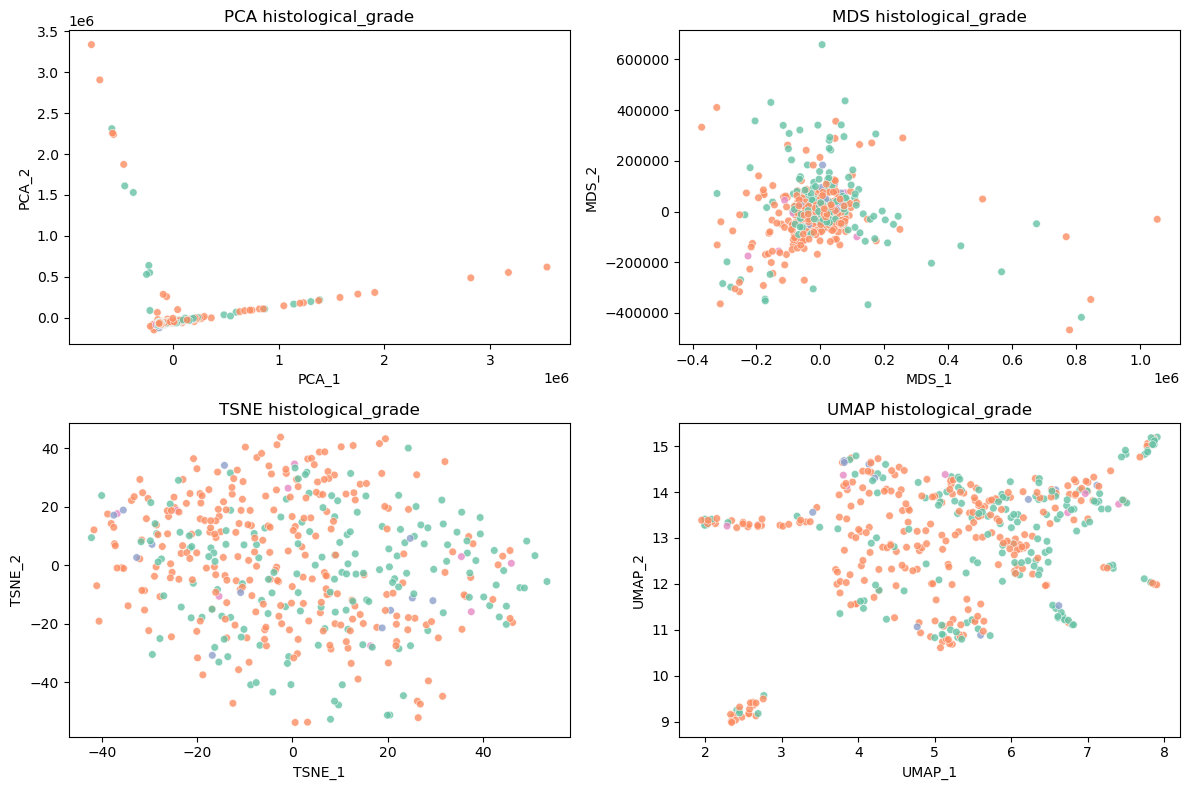

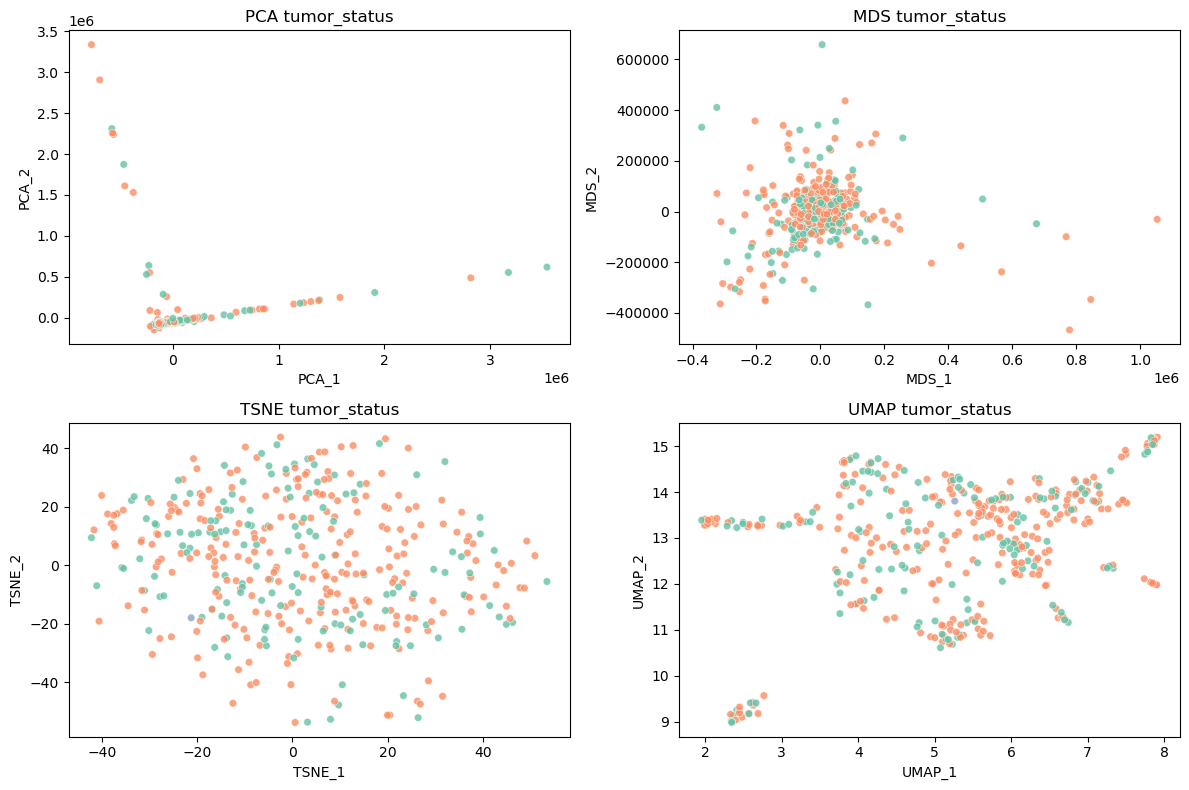

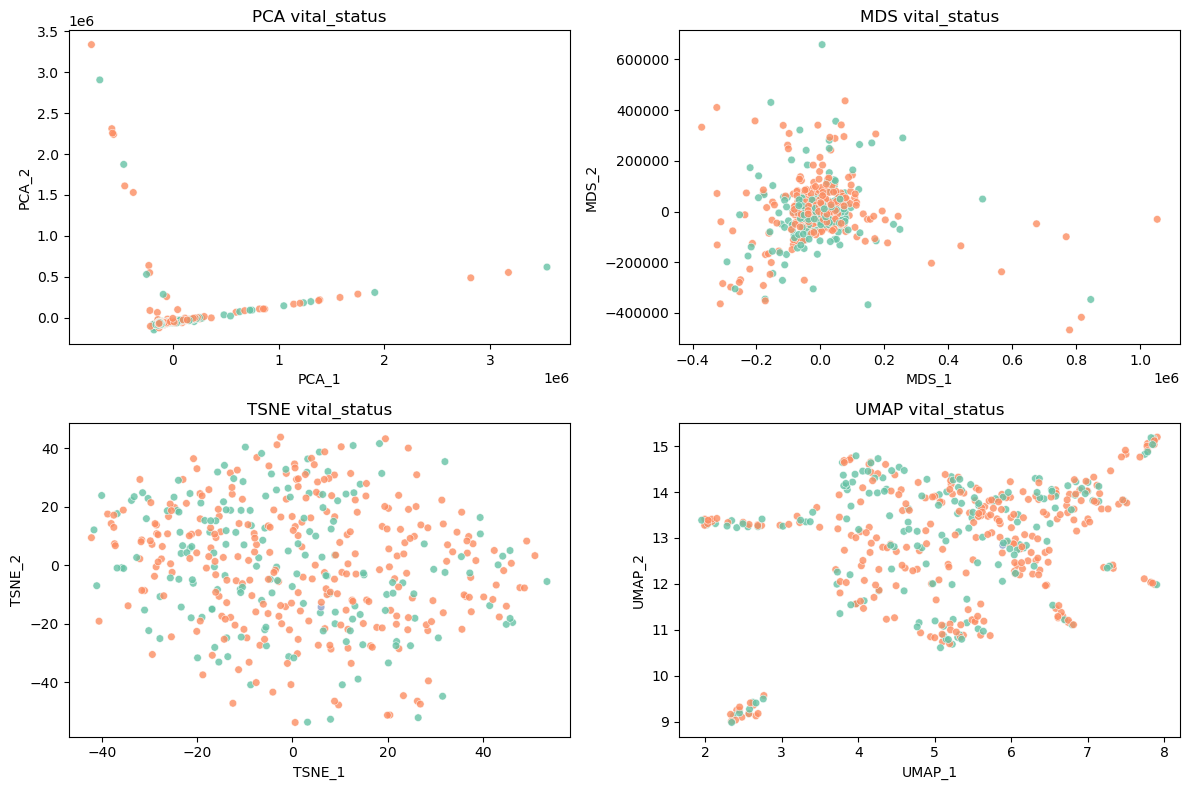

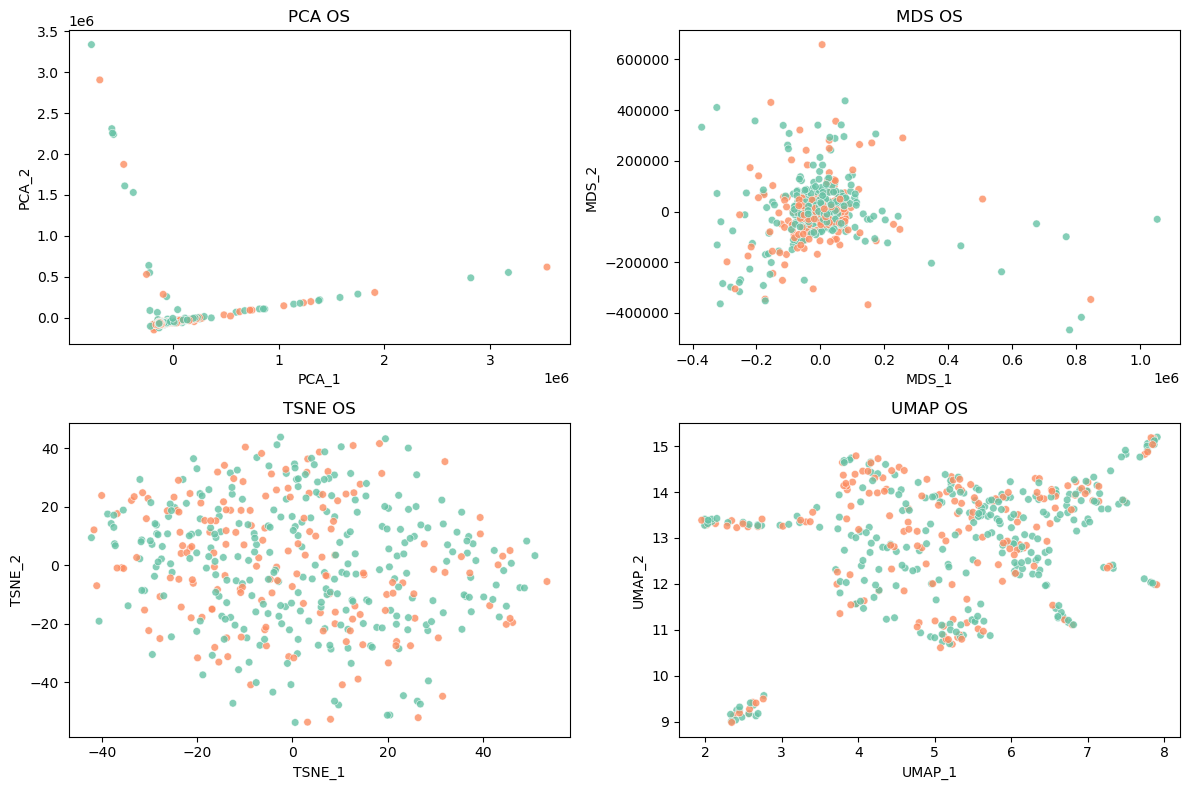

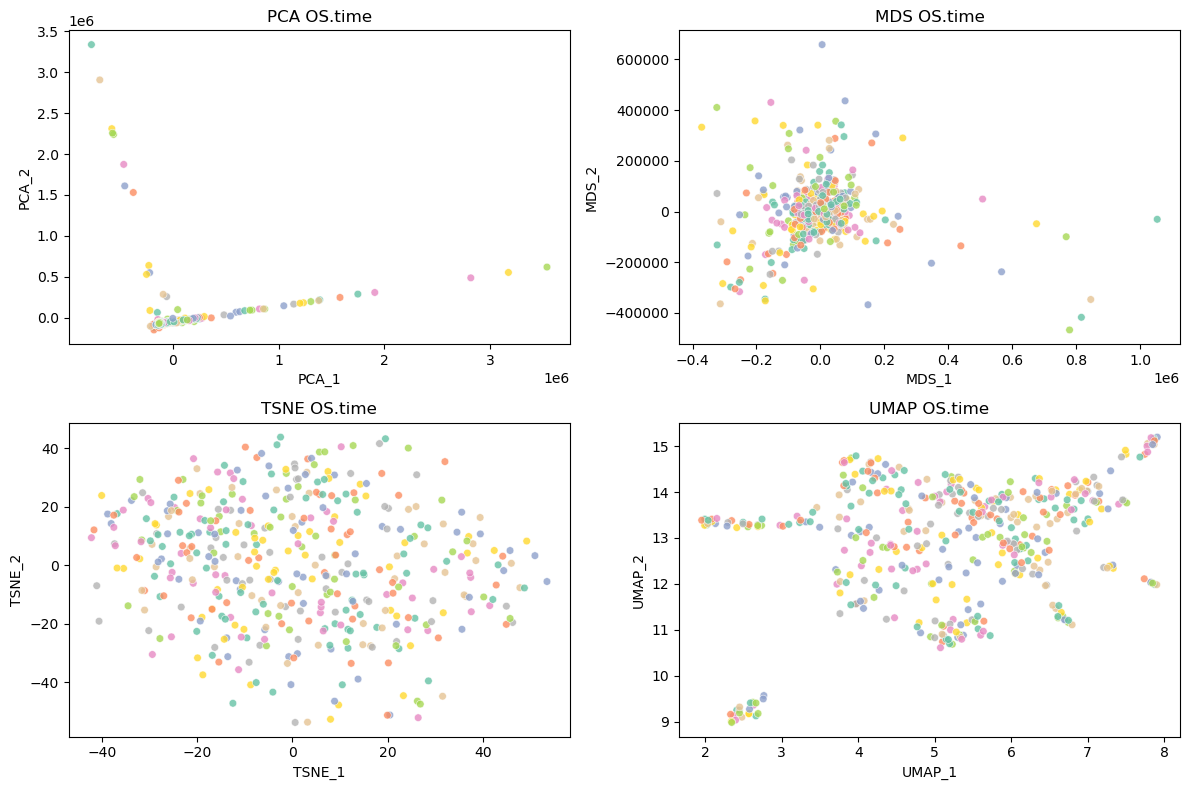

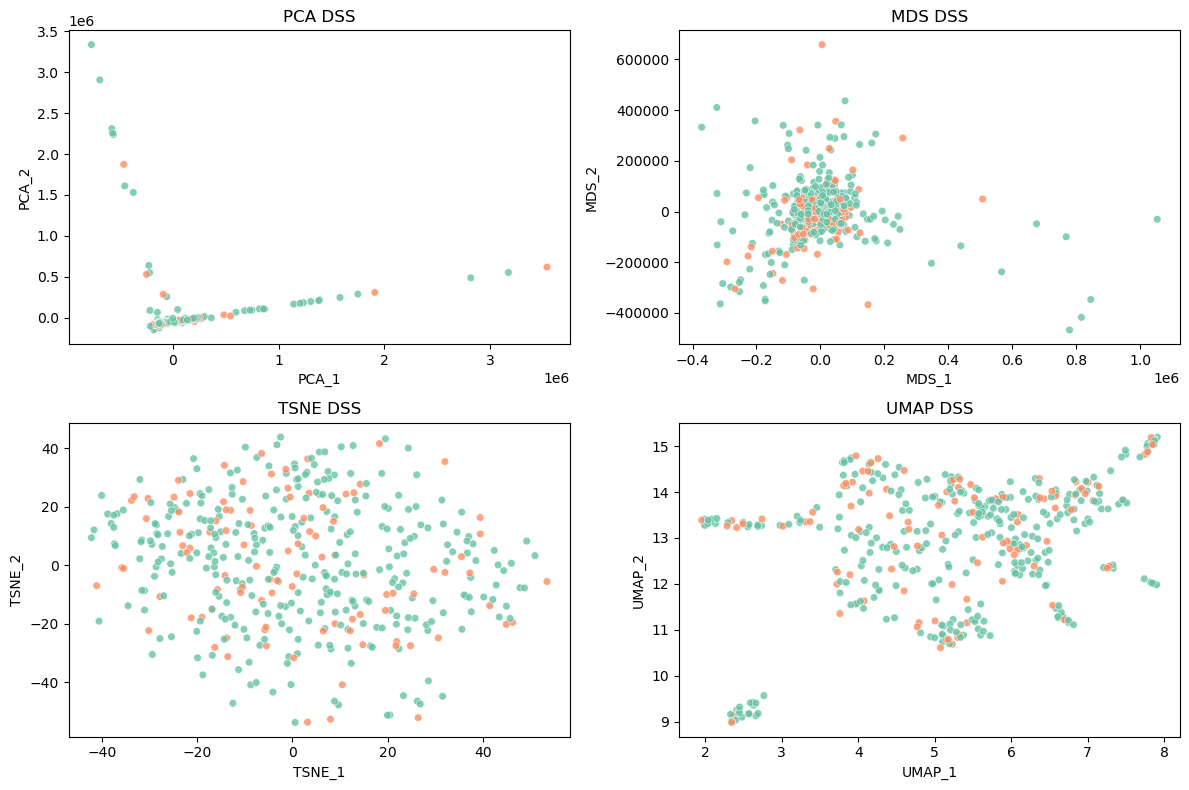

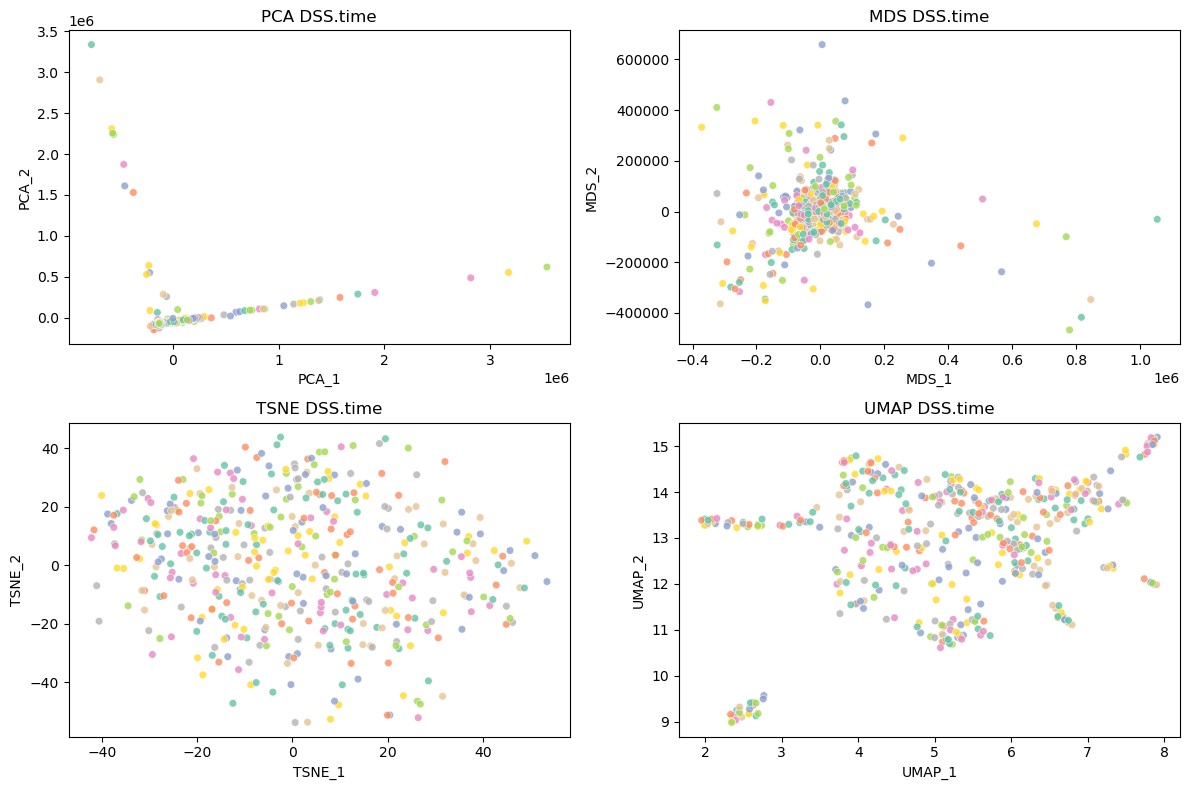

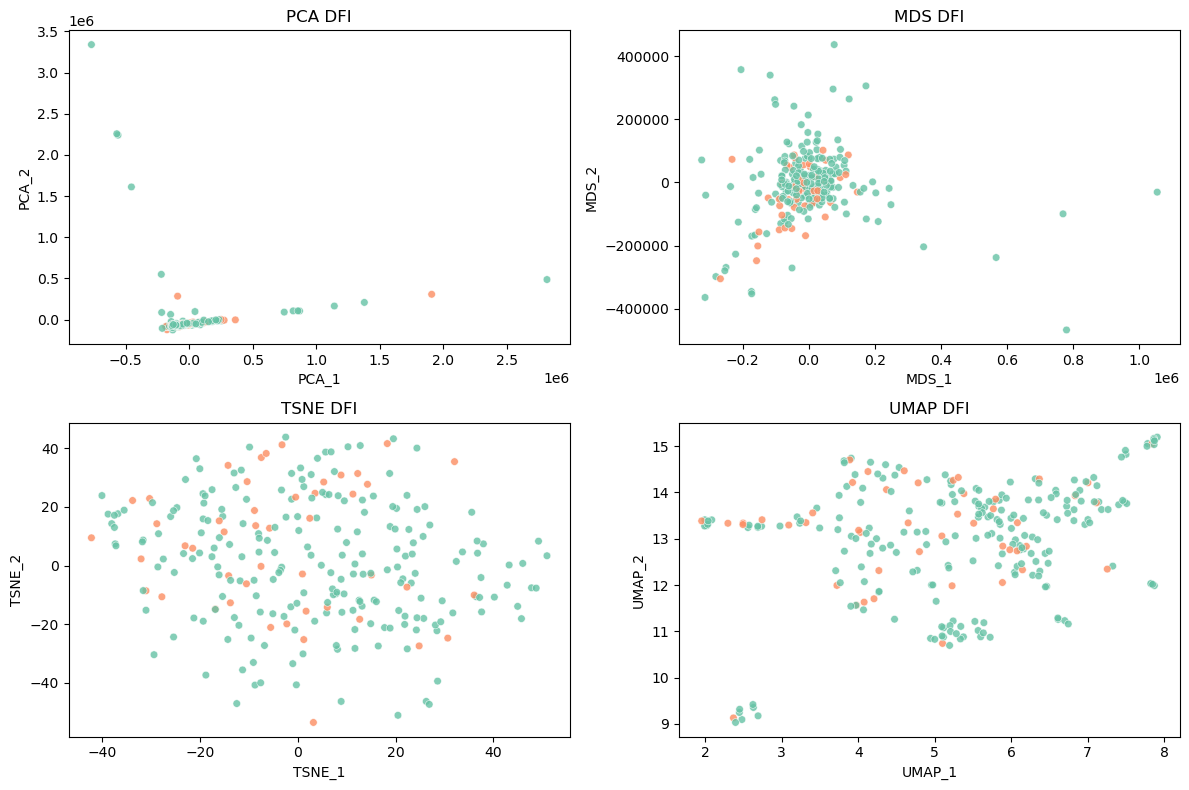

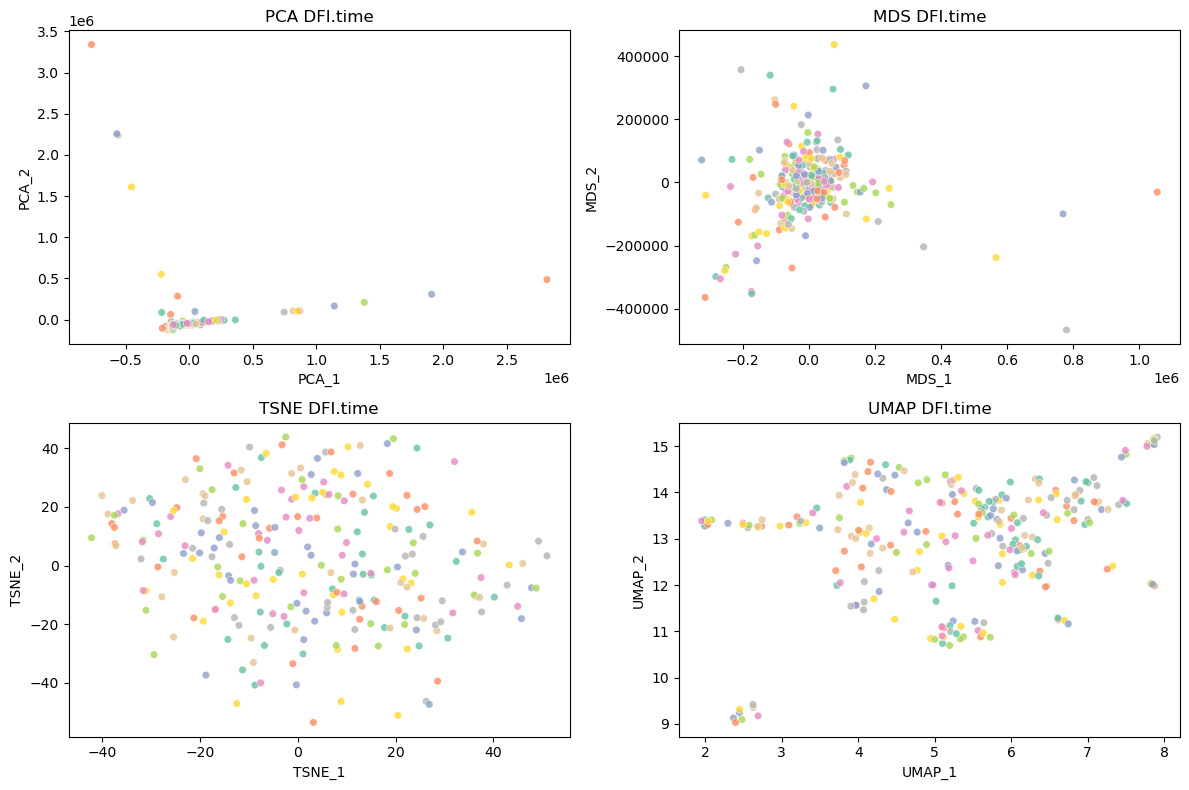

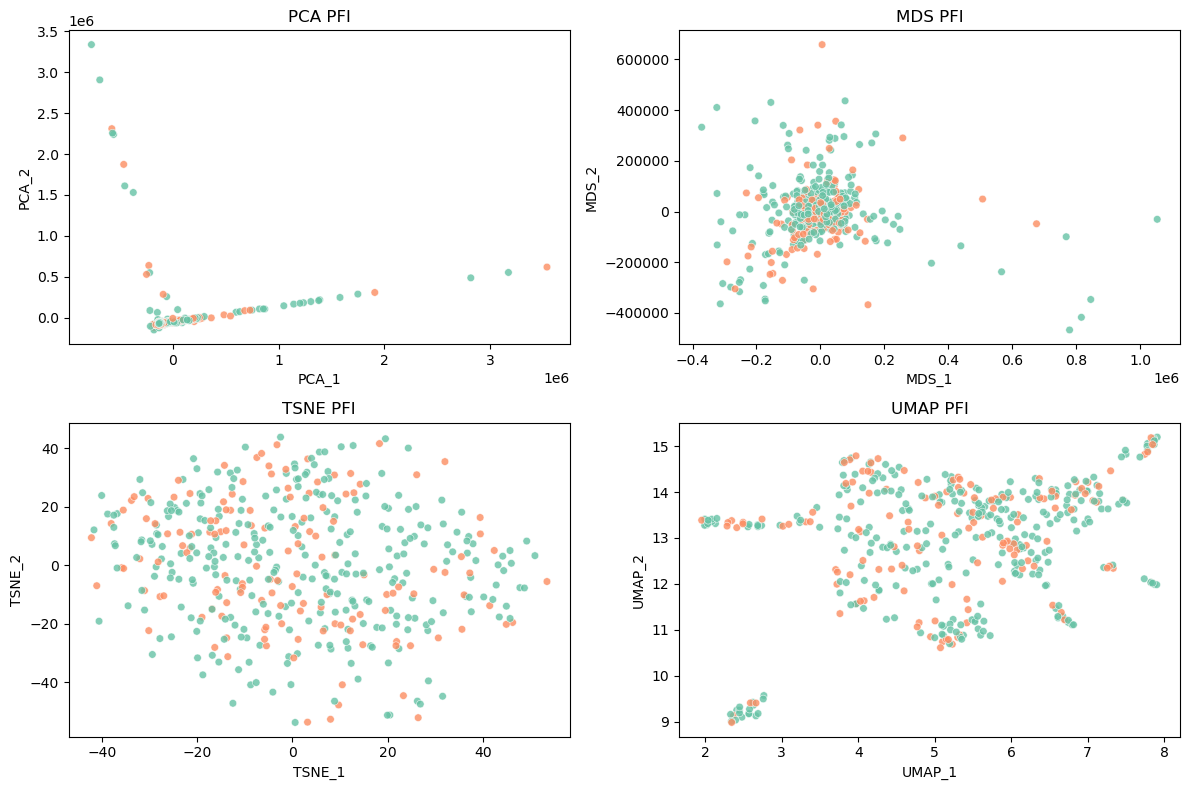

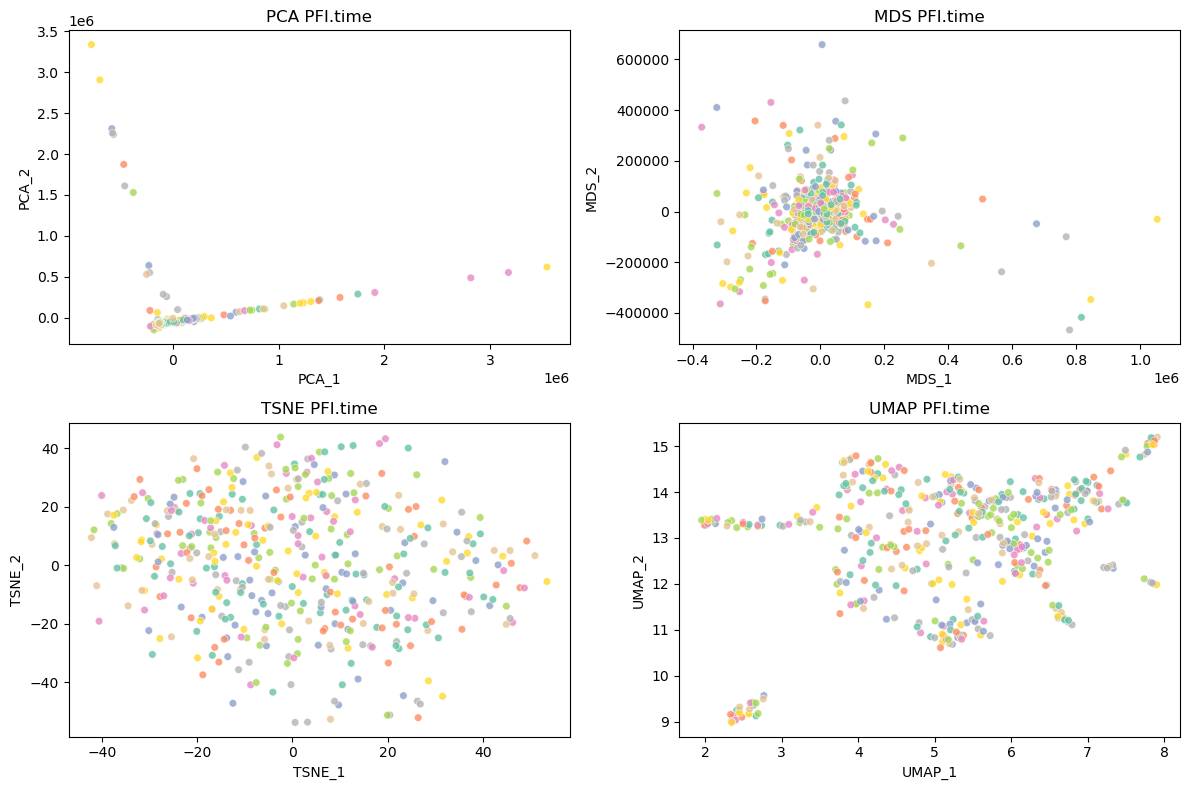

In [17]:
methods = ['pca', 'mds', 'tsne', 'umap']

k = 4

for metric in metadata.columns[1:-1]:
    plt.figure(figsize=(12, 8))
    for i, method in enumerate(methods):
        plt.subplot(2, 2, i+1)
        x_col = method.upper() + '_1'
        y_col = method.upper() + '_2'
        cluster_col = f'{method}_{k}_cluster'

        sns.scatterplot(
            data=results, 
            x=x_col, 
            y=y_col, 
            hue=metric, 
            palette='Set2', 
            s=30, 
            alpha=0.8,
            legend=False
        )
        plt.title(f"{method.upper()} {metric}")
        plt.xlabel(x_col)
        plt.ylabel(y_col)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1125898/3254947943.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = f_oneway(*pca_groups)
/tmp/ipykernel_1125898/3254947943.py:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = f_oneway(*mds_groups)
/tmp/ipykernel_1125898/3254947943.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = f_oneway(*tsne_groups)
/tmp/ipykernel_1125898/3254947943.py:35: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = f_oneway(*umap_groups)


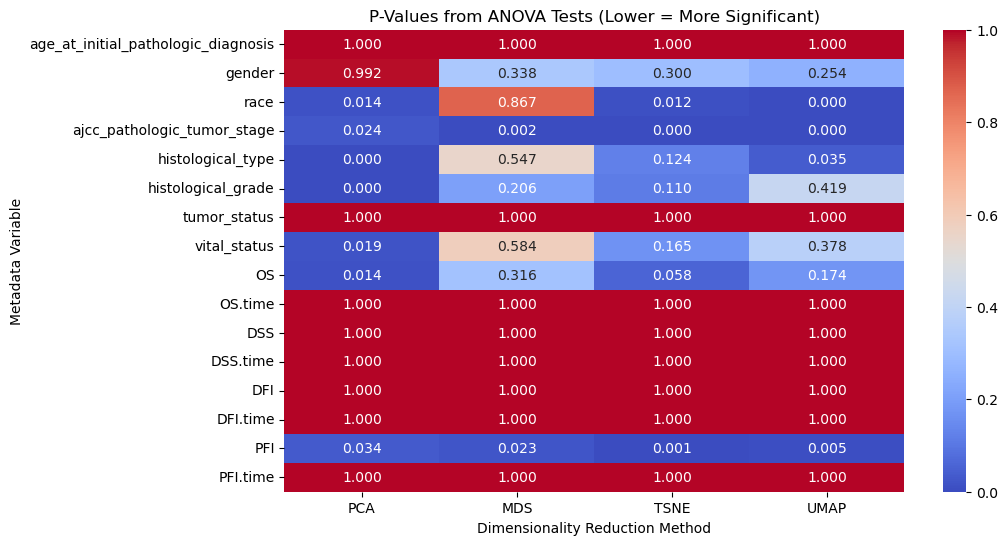

In [151]:
pval_data = {
    "PCA": {},
    "MDS": {},
    "TSNE": {},
    "UMAP": {},
}

for metric in metadata.columns[1:]:
    if len(metadata[metric].unique()) == 1:
        continue

    # PCA
    pca_groups = [results[results[metric] == unique_metric]["PCA_1"] for unique_metric in results[metric].unique()]
    stat, pval = f_oneway(*pca_groups)
    pval = 1.0 if pval is None or np.isnan(pval) else pval
    # print(f"ANOVA (PCA_1 by {metric}): p-value = {pval}")
    pval_data["PCA"][metric] = pval

    # MDS
    mds_groups = [results[results[metric] == unique_metric]["MDS_1"] for unique_metric in results[metric].unique()]
    stat, pval = f_oneway(*mds_groups)
    pval = 1.0 if pval is None or np.isnan(pval) else pval
    # print(f"ANOVA (MDS_1 by {metric}): p-value = {pval}")
    pval_data["MDS"][metric] = pval
    
    # t-SNE
    tsne_groups = [results[results[metric] == unique_metric]["TSNE_1"] for unique_metric in results[metric].unique()]
    stat, pval = f_oneway(*tsne_groups)
    pval = 1.0 if pval is None or np.isnan(pval) else pval
    # print(f"ANOVA (TSNE_1 by {metric}): p-value = {pval}")
    pval_data["TSNE"][metric] = pval
    
    # UMAP (
    umap_groups = [results[results[metric] == unique_metric]["UMAP_1"] for unique_metric in results[metric].unique()]
    stat, pval = f_oneway(*umap_groups)
    pval = 1.0 if pval is None or np.isnan(pval) else pval
    # print(f"ANOVA (UMSP_1 by {metric}): p-value = {pval}")
    pval_data["UMAP"][metric] = pval

pval_df = pd.DataFrame(pval_data)
plt.figure(figsize=(10, 6))
sns.heatmap(pval_df, annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".3f")
plt.title("P-Values from ANOVA Tests (Lower = More Significant)")
plt.ylabel("Metadata Variable")
plt.xlabel("Dimensionality Reduction Method")
plt.show()

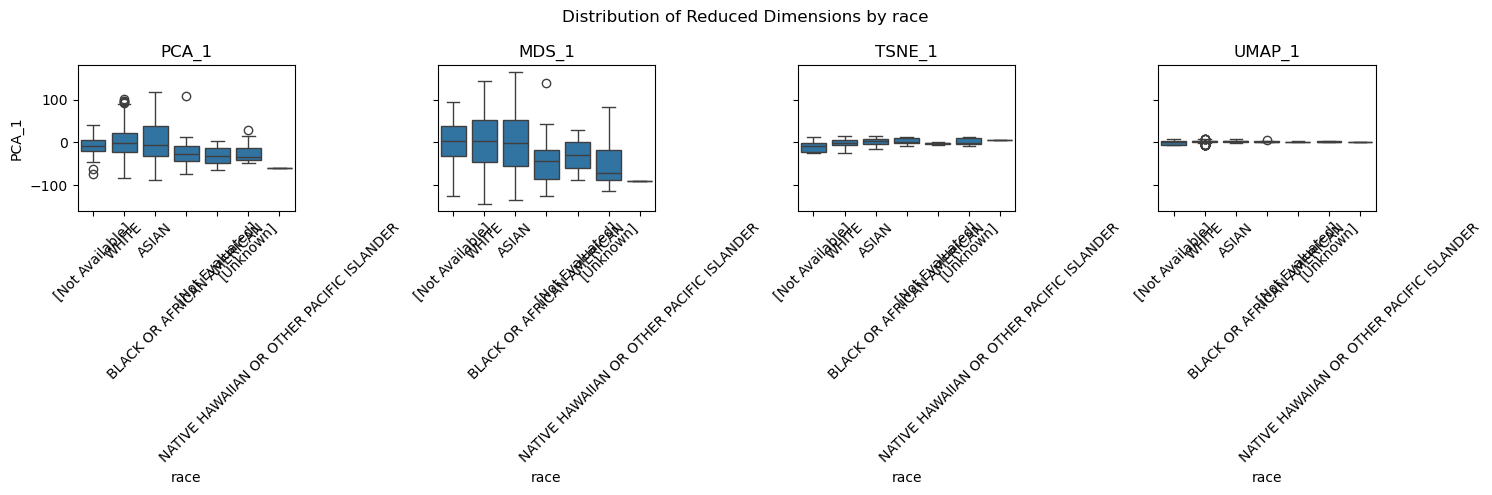

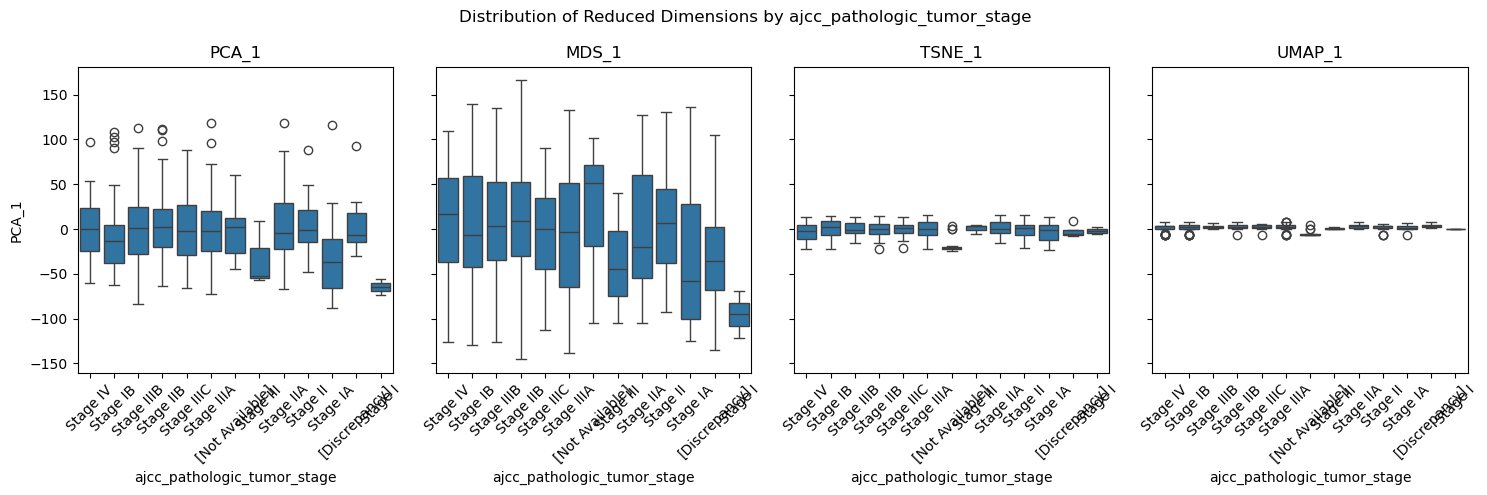

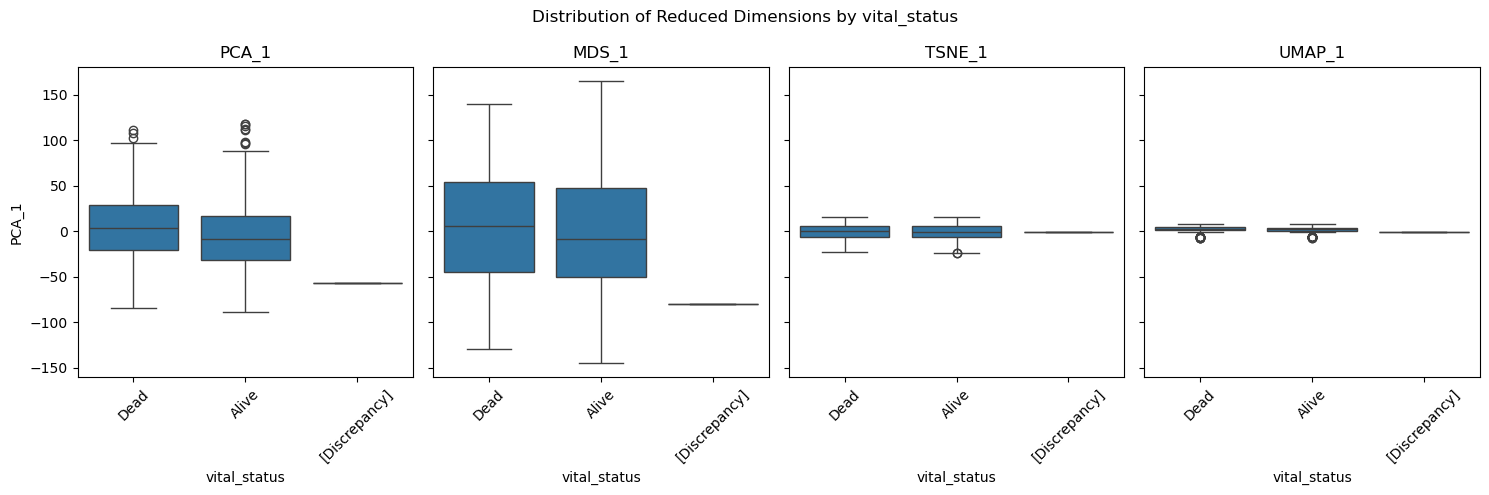

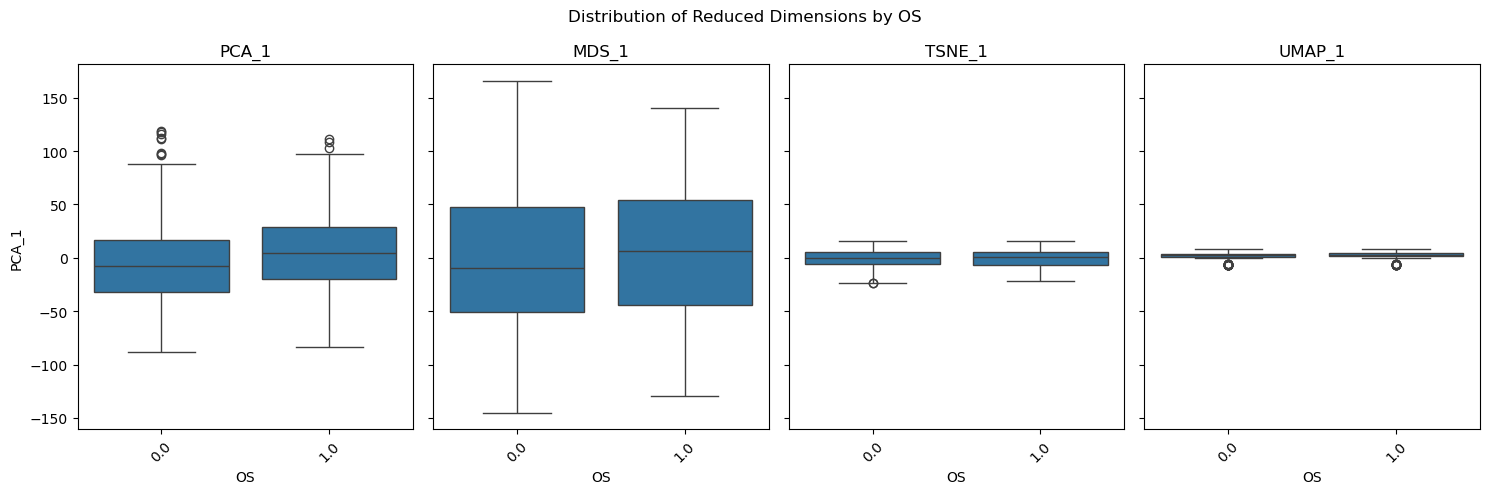

In [111]:
key_metrics = ["race", "ajcc_pathologic_tumor_stage", "vital_status", 'OS']  # Adjust based on your metadata

for metric in key_metrics:
    if len(metadata[metric].unique()) == 1:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Distribution of Reduced Dimensions by {metric}")

    # PCA
    sns.boxplot(x=metric, y="PCA_1", data=results, ax=axes[0])
    axes[0].set_title("PCA_1")
    axes[0].tick_params(axis='x', rotation=45)

    # MDS
    sns.boxplot(x=metric, y="MDS_1", data=results, ax=axes[1])
    axes[1].set_title("MDS_1")
    axes[1].tick_params(axis='x', rotation=45)

    # t-SNE
    sns.boxplot(x=metric, y="TSNE_1", data=results, ax=axes[2])
    axes[2].set_title("TSNE_1")
    axes[2].tick_params(axis='x', rotation=45)
    
     # UMAP
    sns.boxplot(x=metric, y="UMAP_1", data=results, ax=axes[3])
    axes[3].set_title("UMAP_1")
    axes[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [17]:
selected_df = pval_df[pval_df.index.isin(["race", "ajcc_pathologic_tumor_stage", 'histological_type', 'vital_status', 'OS'])]

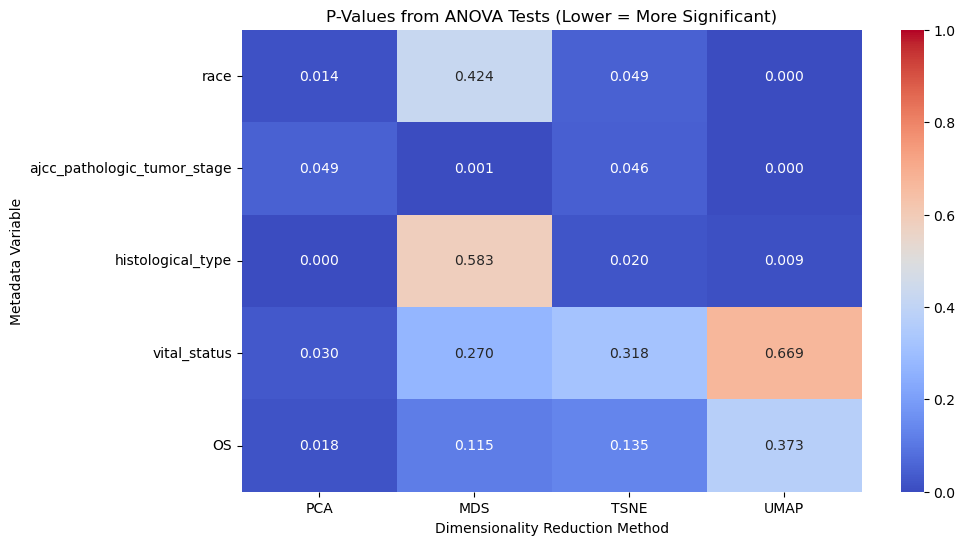

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(selected_df, annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".3f")
plt.title("P-Values from ANOVA Tests (Lower = More Significant)")
plt.ylabel("Metadata Variable")
plt.xlabel("Dimensionality Reduction Method")
plt.show()

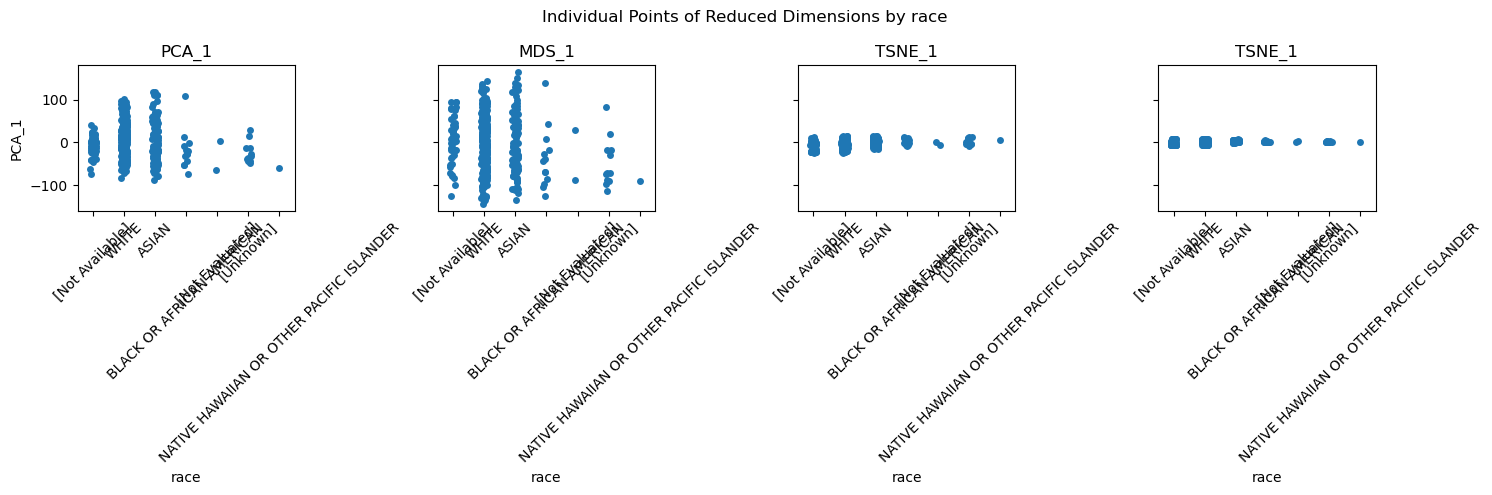

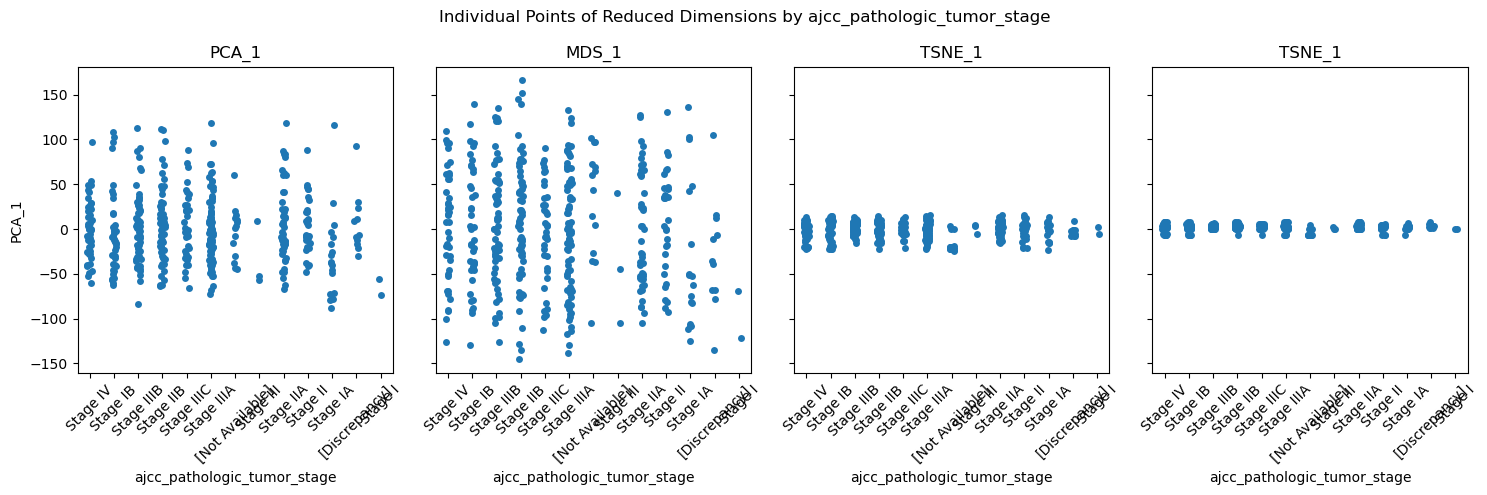

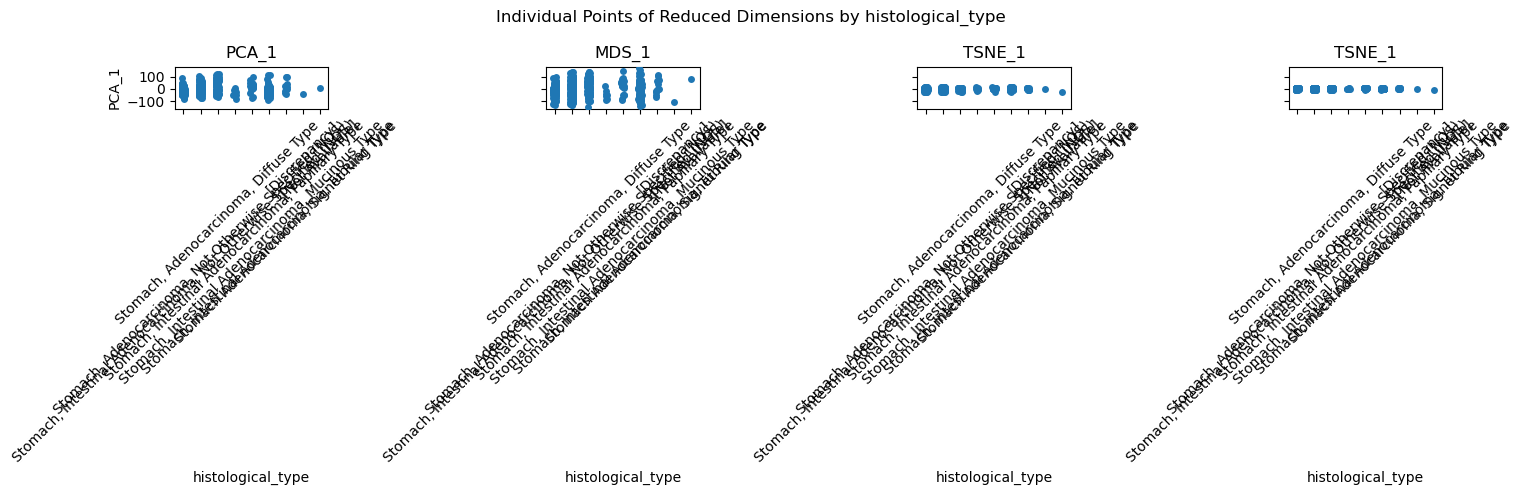

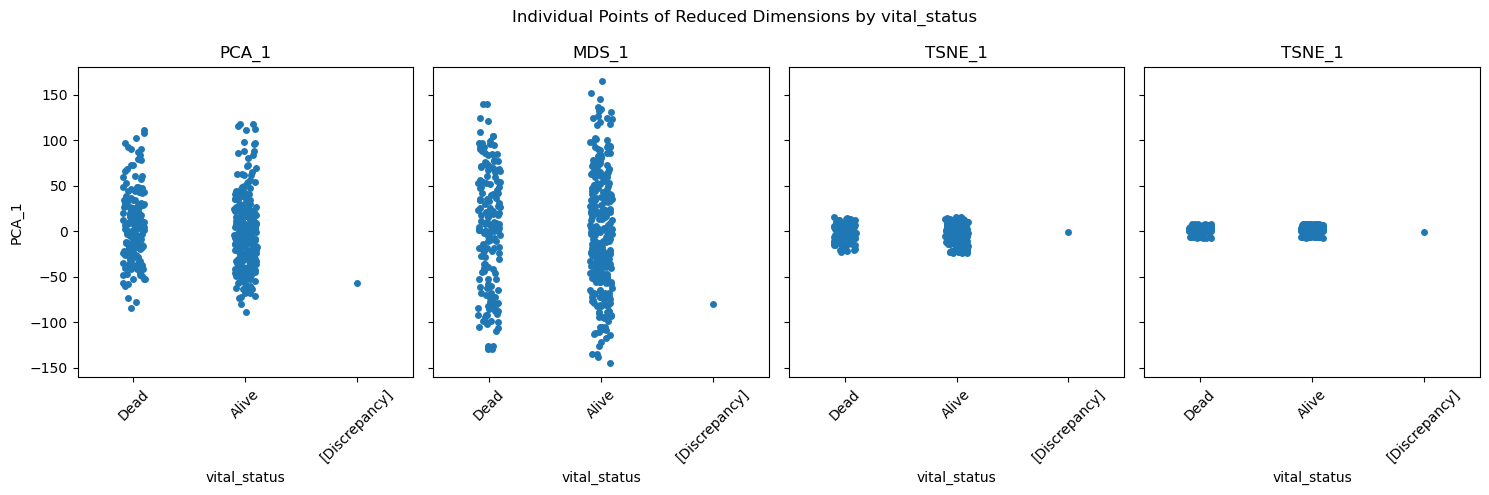

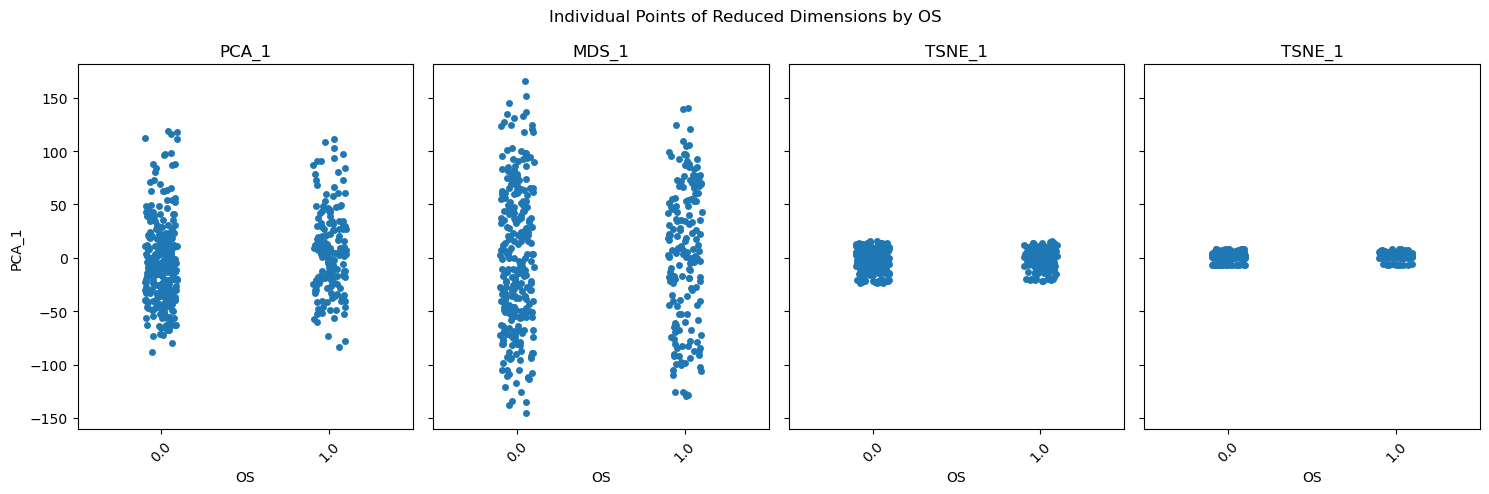

In [112]:
for metric_to_plot in ["race", "ajcc_pathologic_tumor_stage", 'histological_type', 'vital_status', 'OS']:
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Individual Points of Reduced Dimensions by {metric_to_plot}")

    # PCA
    sns.stripplot(x=metric_to_plot, y="PCA_1", data=results, ax=axes[0], jitter=True)
    axes[0].set_title("PCA_1")
    axes[0].tick_params(axis='x', rotation=45)

    # MDS
    sns.stripplot(x=metric_to_plot, y="MDS_1", data=results, ax=axes[1], jitter=True)
    axes[1].set_title("MDS_1")
    axes[1].tick_params(axis='x', rotation=45)

    # t-SNE
    sns.stripplot(x=metric_to_plot, y="TSNE_1", data=results, ax=axes[2], jitter=True)
    axes[2].set_title("TSNE_1")
    axes[2].tick_params(axis='x', rotation=45)
    
    # t-SNE
    sns.stripplot(x=metric_to_plot, y="UMAP_1", data=results, ax=axes[3], jitter=True)
    axes[3].set_title("TSNE_1")
    axes[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

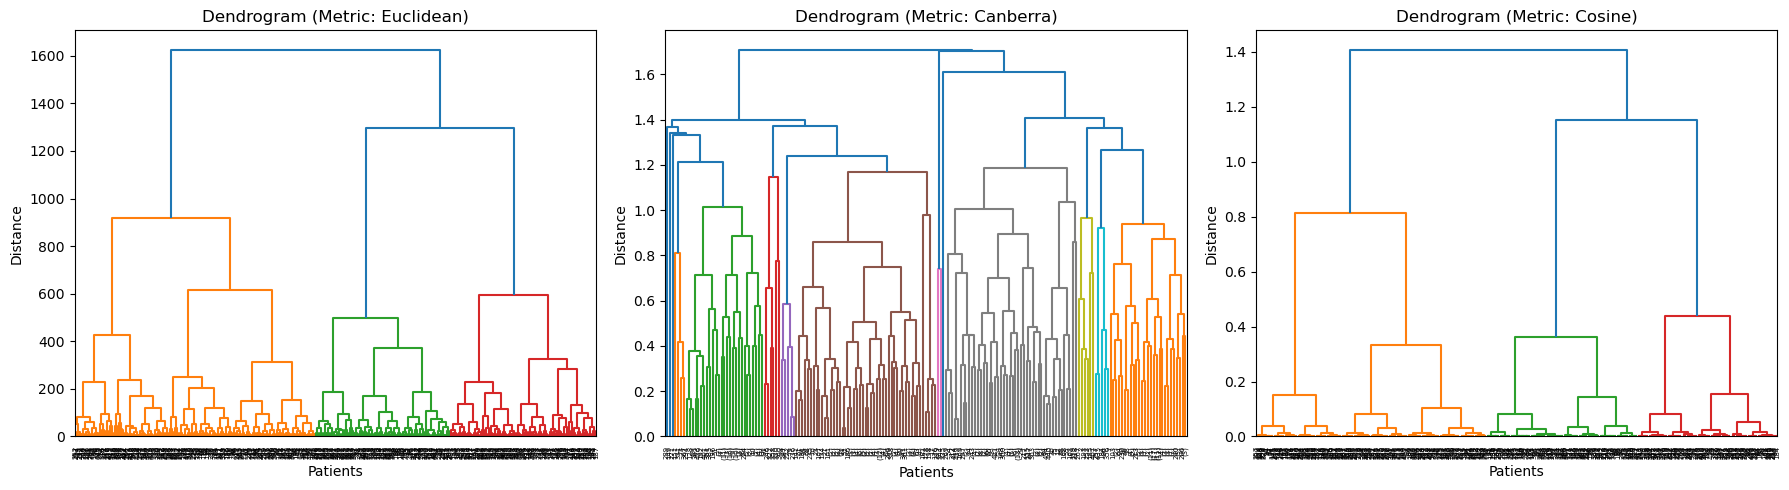

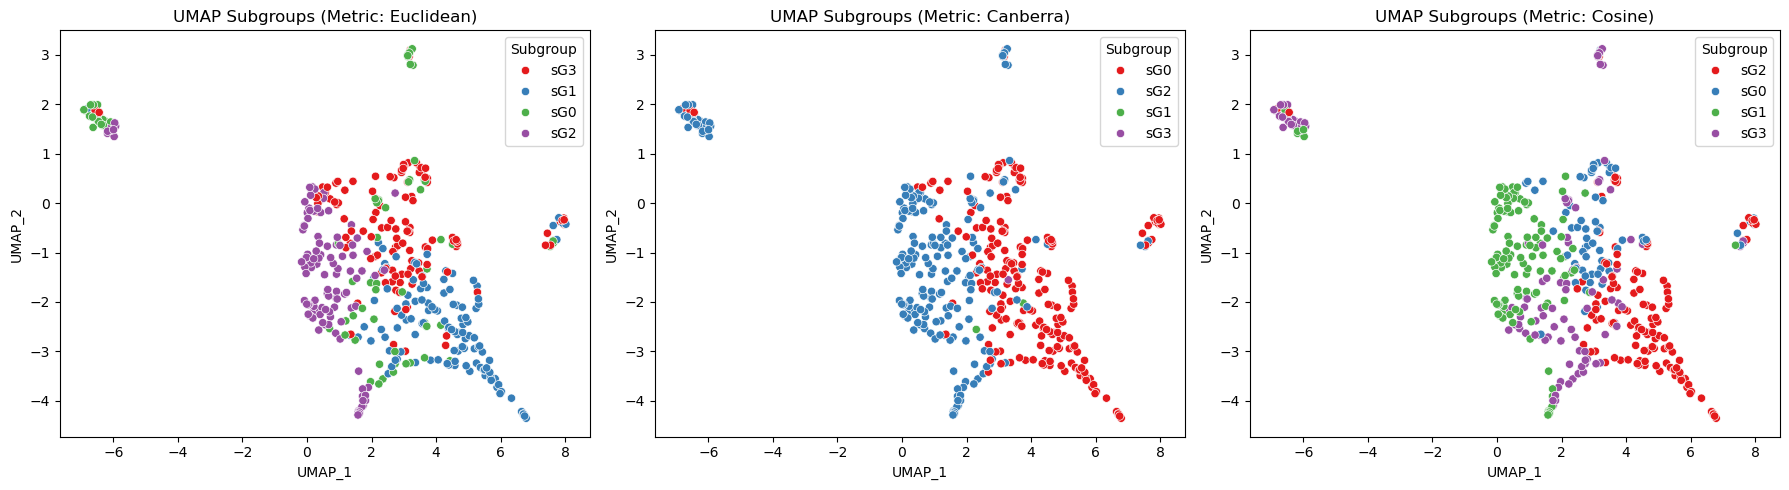

In [114]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

distance_metrics = ["euclidean", "canberra", "cosine"]
linkages = {}
subgroups = {}

for metric in distance_metrics:
    method = "ward" if metric == "euclidean" else "average"
    Z = linkage(mds_result, method=method, metric=metric)
    linkages[metric] = Z
    labels = fcluster(Z, t=4, criterion="maxclust")
    subgroups[metric] = labels

for metric in distance_metrics:
    results[f"Subgroup_{metric}"] = [f"sG{label-1}" for label in subgroups[metric]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    dendrogram(linkages[metric], ax=axes[i], truncate_mode="level", p=10) 
    axes[i].set_title(f"Dendrogram (Metric: {metric.capitalize()})")
    axes[i].set_xlabel("Patients")
    axes[i].set_ylabel("Distance")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"Subgroup_{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

In [28]:
results_reset = results.reset_index()

In [29]:
numeric_meta = ['age_at_initial_pathologic_diagnosis', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time']

/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,
/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,
/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,


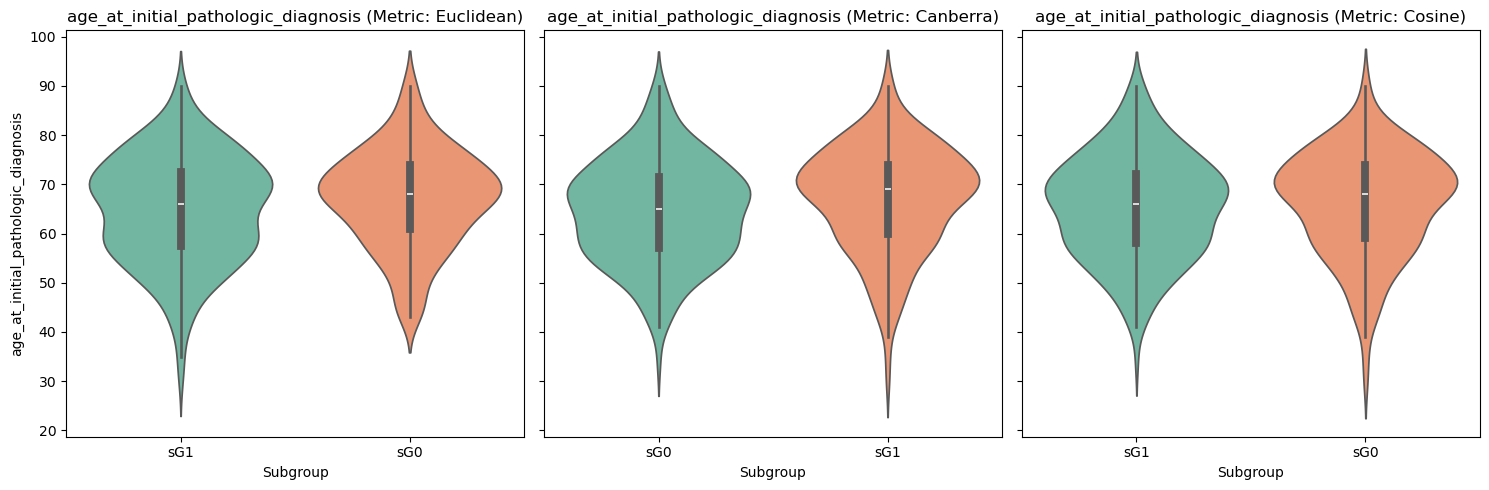

/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,
/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,
/tmp/ipykernel_530919/1434298938.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric,


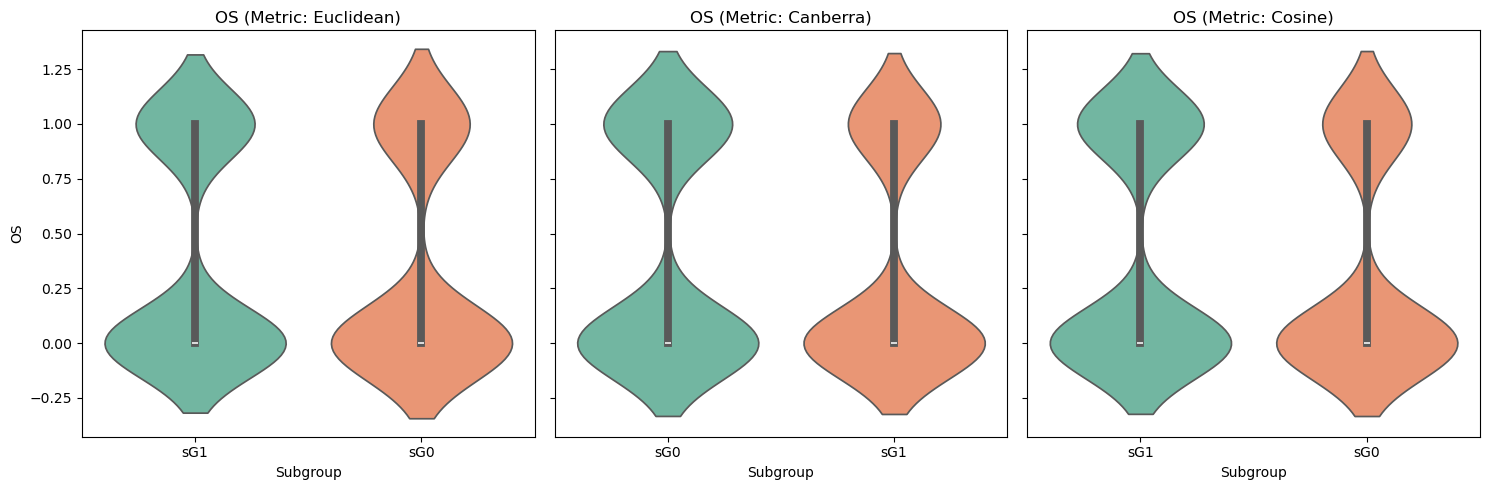

In [ ]:
distance_metrics = ["euclidean", "canberra", "cosine"]

for numeric_metric in numeric_meta:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for i, metric in enumerate(distance_metrics):

        sns.violinplot(x=f"Subgroup_{metric}", y=numeric_metric, 
                       data=results_reset, ax=axes[i], palette="Set2")
        axes[i].set_title(f"{numeric_metric} (Metric: {metric.capitalize()})")
        axes[i].set_xlabel("Subgroup")
        axes[i].set_ylabel(f"{numeric_metric}")

    plt.tight_layout()
    plt.show()

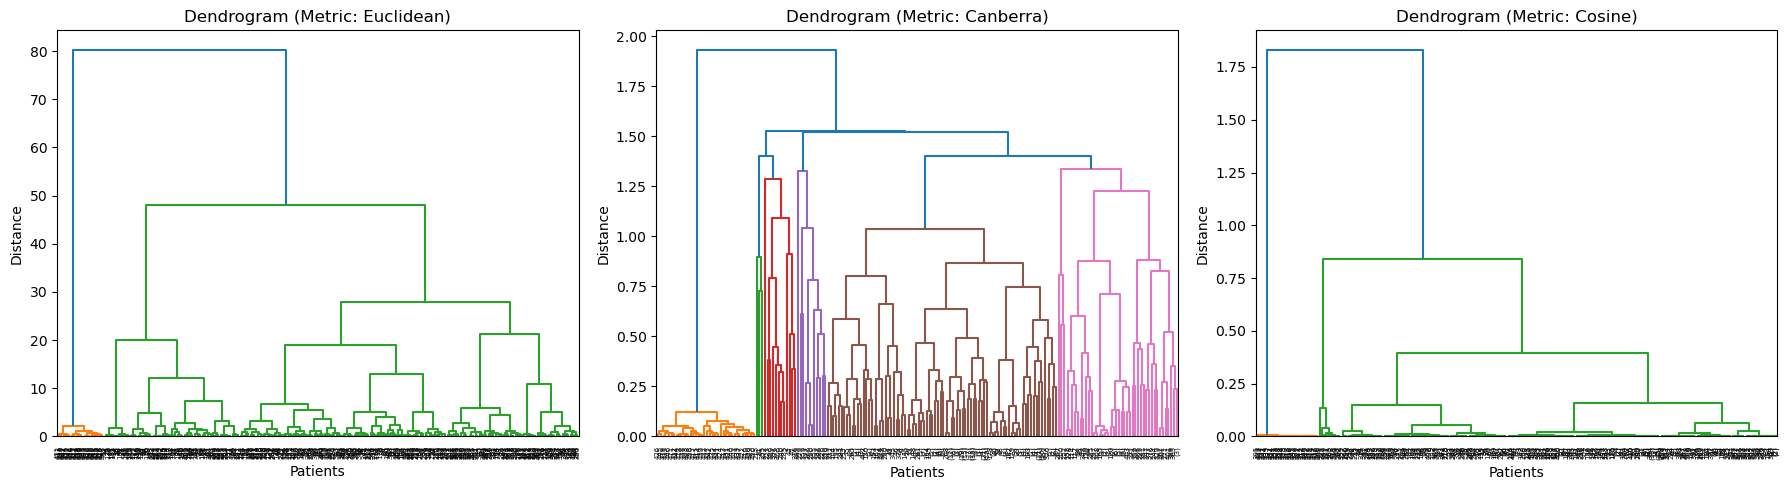

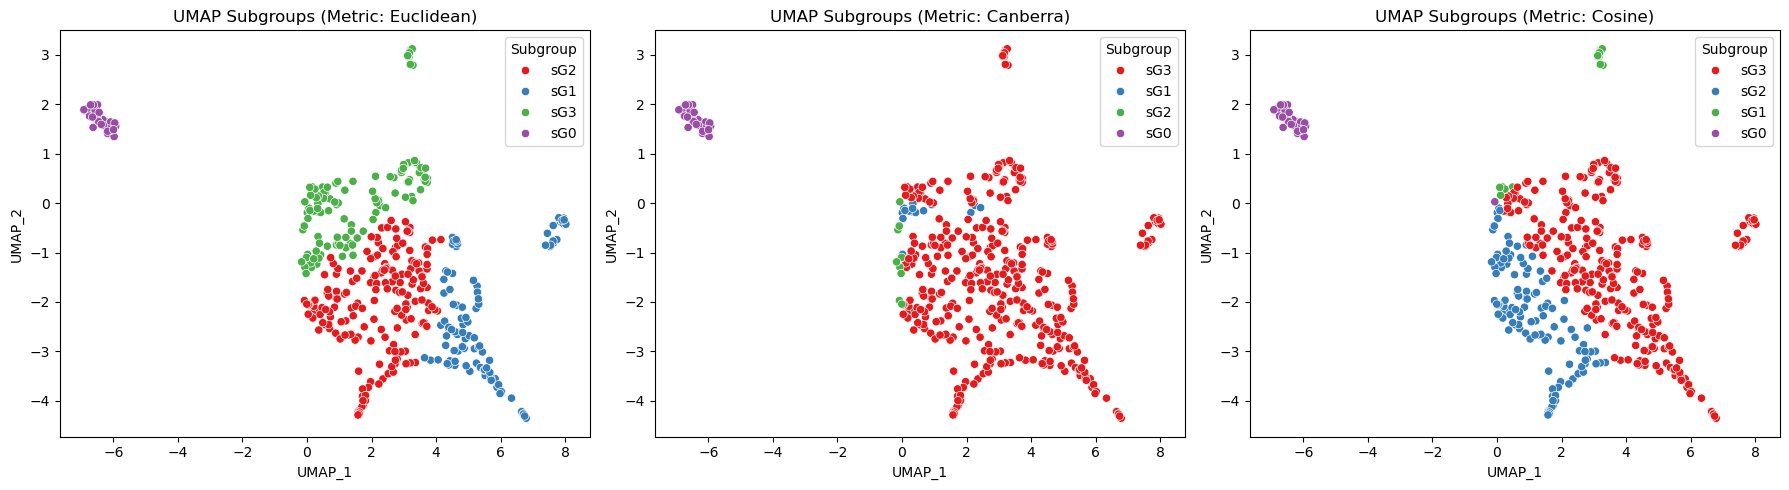

In [116]:
distance_metrics = ["euclidean", "canberra", "cosine"]
linkages = {}
subgroups = {}

for metric in distance_metrics:
    method = "ward" if metric == "euclidean" else "average"
    Z = linkage(umap_result, method=method, metric=metric)
    linkages[metric] = Z
    labels = fcluster(Z, t=4, criterion="maxclust")
    subgroups[metric] = labels

for metric in distance_metrics:
    results[f"Subgroup_{metric}"] = [f"sG{label-1}" for label in subgroups[metric]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    dendrogram(linkages[metric], ax=axes[i], truncate_mode="level", p=10) 
    axes[i].set_title(f"Dendrogram (Metric: {metric.capitalize()})")
    axes[i].set_xlabel("Patients")
    axes[i].set_ylabel("Distance")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"Subgroup_{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

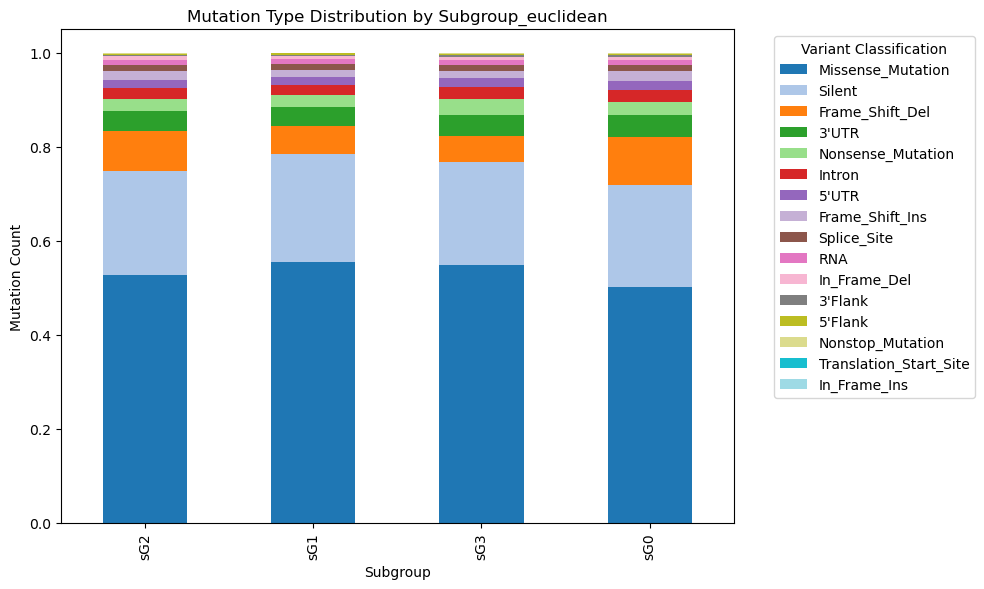

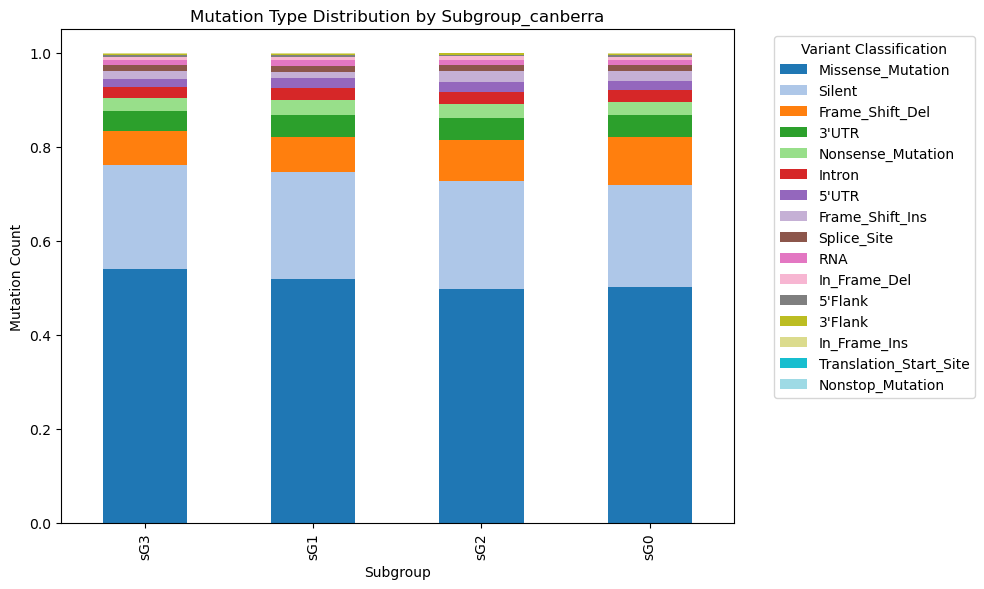

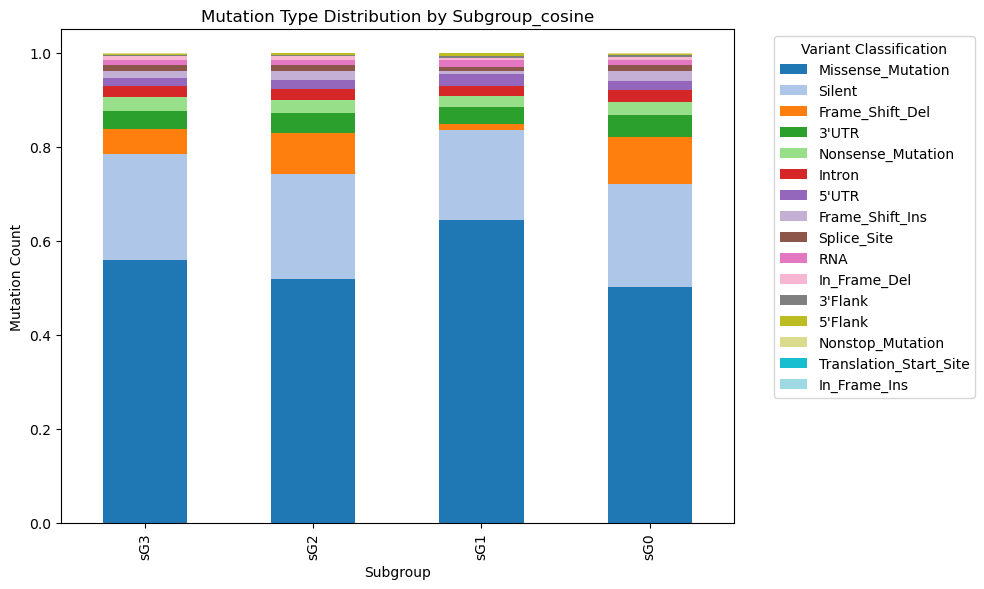

In [117]:
subgroup_cols = ["Subgroup_euclidean", "Subgroup_canberra", "Subgroup_cosine"]

for subgroup_col in subgroup_cols:
    subgroup_counts = {}

    for subgroup in results[subgroup_col].unique():
        patient_ids = results[results[subgroup_col] == subgroup].index
        subgroup_mut = mutations[mutations['patient_id'].isin(patient_ids)]
        counts = subgroup_mut['Variant_Classification'].value_counts()
        subgroup_counts[subgroup] = subgroup_mut['Variant_Classification'].value_counts() / subgroup_mut['Variant_Classification'].value_counts().sum()

    mutation_counts_df = pd.DataFrame(subgroup_counts).fillna(0)
    mutation_counts_df = mutation_counts_df.loc[mutation_counts_df.sum(axis=1).sort_values(ascending=False).index]

    mutation_counts_df.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
    plt.ylabel("Mutation Count")
    plt.xlabel("Subgroup")
    plt.title(f"Mutation Type Distribution by {subgroup_col}")
    plt.legend(title="Variant Classification", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
